# Getting started with TensorFlow

**Learning Objectives**
  1. Practice defining and performing basic operations on constant Tensors
  1. Use Tensorflow's automatic differentiation capability
  1. Learn how to train a linear regression from scratch with TensorFLow


In this notebook, we will start by reviewing the main operations on Tensors in TensorFlow and understand how to manipulate TensorFlow Variables. We explain how these are compatible with python built-in list and numpy arrays. 

Then we will jump to the problem of training a linear regression from scratch with gradient descent. The first order of business will be to understand how to compute the gradients of a function (the loss here) with respect to some of its arguments (the model weights here). The TensorFlow construct allowing us to do that is `tf.GradientTape`, which we will describe. 

At last we will create a simple training loop to learn the weights of a 1-dim linear regression using synthetic data generated from a linear model. 

As a bonus exercise, we will do the same for data generated from a non linear model, forcing us to manual engineer non-linear features to improve our linear model performance.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
print(tf.__version__)

2.1.1


## Operations on Tensors

### Variables and Constants

Tensors in TensorFlow are either contant (`tf.constant`) or variables (`tf.Variable`).
Constant values can not be changed, while variables values can be.

The main difference is that instances of `tf.Variable` have methods allowing us to change 
their values while tensors constructed with `tf.constant` don't have these methods, and
therefore their values can not be changed. When you want to change the value of a `tf.Variable`
`x` use one of the following method: 

* `x.assign(new_value)`
* `x.assign_add(value_to_be_added)`
* `x.assign_sub(value_to_be_subtracted`



In [3]:
x = tf.constant([2, 3, 4])
x

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 3, 4], dtype=int32)>

In [4]:
x = tf.Variable(2.0, dtype=tf.float32, name='my_variable')
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=2.0>

**Exercise.** Use the `assign(..)` method to assign a new value to the variable `x` you created above. After each, print `x` to verify how the value changes. 

In [5]:
x.assign_add(4) # TODO: Your code goes here. 
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=6.0>

In [6]:
x.assign(1) # TODO: Your code goes here. 
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=1.0>

In [7]:
x.assign_sub(3) # TODO: Your code goes here. 
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=-2.0>

### Point-wise operations

Tensorflow offers similar point-wise tensor operations as numpy does:
    
* `tf.add` allows to add the components of a tensor 
* `tf.multiply` allows us to multiply the components of a tensor
* `tf.subtract` allow us to substract the components of a tensor
* `tf.math.*` contains the usual math operations to be applied on the components of a tensor
* and many more...

Most of the standard aritmetic operations (`tf.add`, `tf.substrac`, etc.) are overloaded by the usual corresponding arithmetic symbols (`+`, `-`, etc.)

**Exercise.** Create two tensorflow constants `a = [5, 3, 8]` and `b = [3, -1, 2]`. Then, compute 
1. the sum of the constants `a` and `b` below using `tf.add` and `+` and verify both operations produce the same values.
2. the product of the constants `a` and `b` below using `tf.multiply` and `*` and verify both operations produce the same values.
3. the exponential of the constant `a` using `tf.math.exp`. Note, you'll need to specify the type for this operation.


In [8]:
a = tf.constant([5, 3, 8]) # TODO: Your code goes here.
b = tf.constant([3, -1, 2]) # TODO: Your code goes here.
c = tf.add(a, b) # TODO: Your code goes here.
d = a + b # TODO: Your code goes here.

print("c:", c)
print("d:", d)

c: tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)
d: tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)


In [9]:
a = tf.constant([5, 3, 8]) # TODO: Your code goes here.
b = tf.constant([3, -1, 2]) # TODO: Your code goes here.
c = tf.multiply(a, b) # TODO: Your code goes here.
d = a * b # TODO: Your code goes here.

print("c:", c)
print("d:", d)

c: tf.Tensor([15 -3 16], shape=(3,), dtype=int32)
d: tf.Tensor([15 -3 16], shape=(3,), dtype=int32)


In [10]:
# tf.math.exp expects floats so we need to explicitly give the type
a = tf.constant([5, 3, 8], dtype=tf.float32) # TODO: Your code goes here.
b = tf.math.exp(a) # TODO: Your code goes here.

print("b:", b)

b: tf.Tensor([ 148.41316    20.085537 2980.958   ], shape=(3,), dtype=float32)


### NumPy Interoperability

In addition to native TF tensors, tensorflow operations can take native python types and NumPy arrays as operands. 

In [11]:
# native python list
a_py = [1, 2] 
b_py = [3, 4] 

**Exercise.** Use `tf.add` to compute the sum of the native python arrays `a` and `b`. 

In [12]:
#TODO: Your code goes here.
c_py = tf.add(a_py, b_py)
c_py

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

In [14]:
# numpy arrays
a_np = np.array([1, 2])
b_np = np.array([3, 4])

**Exercise.** Use `tf.add` to compute the sum of the NumPy arrays `a` and `b`. 

In [15]:
#TODO: Your code goes here.
c_np = tf.add(a_np, b_np)
c_np

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([4, 6])>

In [16]:
# native TF tensor
a_tf = tf.constant([1, 2])
b_tf = tf.constant([3, 4])

**Exercise.** Use `tf.add` to compute the sum of the Tensorflow constants `a` and `b`. 

In [17]:
c_tf = tf.add(a_tf, b_tf)
c_tf

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

You can convert a native TF tensor to a NumPy array using .numpy()

In [18]:
a_tf.numpy()

array([1, 2], dtype=int32)

## Linear Regression

Now let's use low level tensorflow operations to implement linear regression.

Later in the course you'll see abstracted ways to do this using high level TensorFlow.

### Toy Dataset

We'll model the following function:

\begin{equation}
y= 2x + 10
\end{equation}

In [19]:
X = tf.constant(range(10), dtype=tf.float32)
Y = 2 * X + 10

print("X:{}".format(X))
print("Y:{}".format(Y))

X:[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Y:[10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]


Let's also create a test dataset to evaluate our models:

In [20]:
X_test = tf.constant(range(10, 20), dtype=tf.float32)
Y_test = 2 * X_test + 10

print("X_test:{}".format(X_test))
print("Y_test:{}".format(Y_test))

X_test:[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
Y_test:[30. 32. 34. 36. 38. 40. 42. 44. 46. 48.]


#### Loss Function

The simplest model we can build is a model that for each value of x returns the sample mean of the training set:

In [21]:
y_mean = Y.numpy().mean()


def predict_mean(X):
    y_hat = [y_mean] * len(X)
    return y_hat

Y_hat = predict_mean(X_test)

Using mean squared error, our loss is:
\begin{equation}
MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y}_i-Y_i)^2
\end{equation}

For this simple model the loss is then:

In [22]:
errors = (Y_hat - Y)**2
loss = tf.reduce_mean(errors)
loss.numpy()

33.0

This values for the MSE loss above will give us a baseline to compare how a more complex model is doing.

Now, if $\hat{Y}$ represents the vector containing our model's predictions when we use a linear regression model
\begin{equation}
\hat{Y} = w_0X + w_1
\end{equation}

we can write a loss function taking as arguments the coefficients of the model:

In [23]:
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

### Gradient Function

To use gradient descent we need to take the partial derivatives of the loss function with respect to each of the weights. We could manually compute the derivatives, but with Tensorflow's automatic differentiation capabilities we don't have to!

During gradient descent we think of the loss as a function of the parameters $w_0$ and $w_1$. Thus, we want to compute the partial derivative with respect to these variables. 

For that we need to wrap our loss computation within the context of `tf.GradientTape` instance which will reccord gradient information:

```python
with tf.GradientTape() as tape:
    loss = # computation 
```

This will allow us to later compute the gradients of any tensor computed within the `tf.GradientTape` context with respect to instances of `tf.Variable`:

```python
gradients = tape.gradient(loss, [w0, w1])
```

We illustrate this procedure with by computing the loss gradients with respect to the model weights:

**Lab Task #6:** Complete the function below to compute the loss gradients with respect to the model weights `w0` and `w1`. 

In [24]:
def compute_gradients(X, Y, w0, w1):
    # TODO: Your code goes here.
    with tf.GradientTape() as tape:
        loss = loss_mse(X, Y, w0, w1)
    return (tape.gradient(loss, [w0, w1]))

In [25]:
w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dw0, dw1 = compute_gradients(X, Y, w0, w1)

In [26]:
print("dw0:", dw0.numpy())

dw0: -204.0


In [27]:
print("dw1", dw1.numpy())

dw1 -38.0


### Training Loop

Here we have a very simple training loop that converges. Note we are ignoring best practices like batching, creating a separate test set, and random weight initialization for the sake of simplicity.

**Lab Task #7:** Complete the `for` loop below to train a linear regression. 
1. Use `compute_gradients` to compute `dw0` and `dw1`.
2. Then, re-assign the value of `w0` and `w1` using the `.assign_sub(...)` method with the computed gradient values and the `LEARNING_RATE`.
3. Finally, for every 100th step , we'll compute and print the `loss`. Use the `loss_mse` function we created above to compute the `loss`. 

In [28]:
STEPS = 1000
LEARNING_RATE = .02
MSG = "STEP {step} - loss: {loss}, w0: {w0}, w1: {w1}\n"


w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)


for step in range(0, STEPS + 1):

    dw0, dw1 = compute_gradients(X, Y, w0, w1) #TODO: Your code goes here.
    w0.assign_sub(dw0 * LEARNING_RATE) #TODO: Your code goes here.
    w1.assign_sub(dw1 * LEARNING_RATE) #TODO: Your code goes here.

    if step % 100 == 0:
        loss = loss_mse(X, Y, w0, w1) #TODO: Your code goes here.
        print(MSG.format(step=step, loss=loss, w0=w0.numpy(), w1=w1.numpy()))


STEP 0 - loss: 35.70719528198242, w0: 4.079999923706055, w1: 0.7599999904632568

STEP 100 - loss: 2.6017532348632812, w0: 2.4780430793762207, w1: 7.002389907836914

STEP 200 - loss: 0.26831889152526855, w0: 2.153517961502075, w1: 9.037351608276367

STEP 300 - loss: 0.027671903371810913, w0: 2.0493006706237793, w1: 9.690855979919434

STEP 400 - loss: 0.0028539239428937435, w0: 2.0158326625823975, w1: 9.90071964263916

STEP 500 - loss: 0.0002943490108009428, w0: 2.005084753036499, w1: 9.96811580657959

STEP 600 - loss: 3.0356444767676294e-05, w0: 2.0016329288482666, w1: 9.989760398864746

STEP 700 - loss: 3.1322738323069643e-06, w0: 2.0005245208740234, w1: 9.996710777282715

STEP 800 - loss: 3.2238213520940917e-07, w0: 2.0001683235168457, w1: 9.998944282531738

STEP 900 - loss: 3.369950718479231e-08, w0: 2.000054359436035, w1: 9.999658584594727

STEP 1000 - loss: 3.6101481803996194e-09, w0: 2.0000178813934326, w1: 9.99988842010498



Now let's compare the test loss for this linear regression to the test loss from the baseline model that outputs always the mean of the training set:

In [29]:
loss = loss_mse(X_test, Y_test, w0, w1)
loss.numpy()

2.4563633e-08

This is indeed much better!

## Bonus

Try modelling a non-linear function such as: $y=xe^{-x^2}$

In [30]:
X = tf.constant(np.linspace(0, 2, 1000), dtype=tf.float32)
Y = X * tf.exp(-X**2)

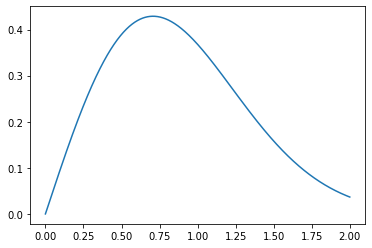

In [31]:
%matplotlib inline

plt.plot(X, Y)

In [47]:
def make_features(X):
    f1 = tf.ones_like(X)  # Bias. JOSE: all ones with the same shape as X
    f2 = X
#    f3 = tf.square(X)
    f3 = tf.math.pow(X, 1.5)
    f4 = tf.sqrt(X)
    f5 = tf.exp(X)
    return tf.stack([f1, f2, f3, f4, f5], axis=1) #JOSE: Create input tensor with features

In [48]:
def predict(X, W):
    return tf.squeeze(X @ W, -1)

In [49]:
def loss_mse(X, Y, W):
    Y_hat = predict(X, W)
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

In [50]:
def compute_gradients(X, Y, W):
    with tf.GradientTape() as tape:
        loss = loss_mse(Xf, Y, W)
    return tape.gradient(loss, W)

STEP: 2000 MSE: 0.0030694908928126097


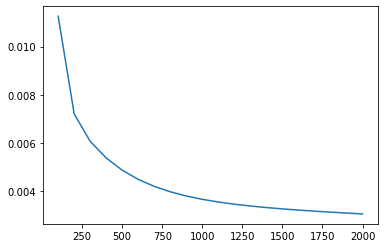

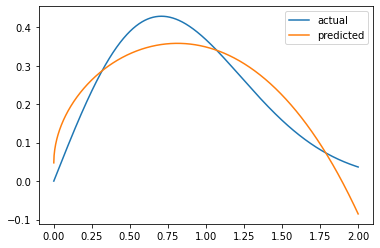

In [51]:
STEPS = 2000
LEARNING_RATE = .02


Xf = make_features(X)
n_weights = Xf.shape[1]

W = tf.Variable(np.zeros((n_weights, 1)), dtype=tf.float32)

# For plotting
steps, losses = [], []
plt.figure()


for step in range(1, STEPS + 1):

    dW = compute_gradients(X, Y, W)
    W.assign_sub(dW * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(Xf, Y, W)
        steps.append(step)
        losses.append(loss)
        plt.clf()
        plt.plot(steps, losses)


print("STEP: {} MSE: {}".format(STEPS, loss_mse(Xf, Y, W)))

plt.figure()
plt.plot(X, Y, label='actual')
plt.plot(X, predict(Xf, W), label='predicted')
plt.legend()

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License